In [1]:
# Parameters cell

# Model
MODEL_LOC = None
MODEL = "babbage-002"
# MODEL = "df@meta-llama/Llama-2-70b-chat-hf"

# Conditioners
CONDITIONERS = 1

# Sample rate
SAMPLE_RATE = -100

# Debug
DEBUG = False

# Corpus
CORPUS_NAME = "dog_ownership"

# The name of the experiment (i.e. where to save the results)
EXPERIMENT_NAME = "test_ignore_me"

# The size of the corpus
CORPUS_SIZE = "/20_10"

In [2]:
CORPUS = (
    "/workspaces/dev/projects/narratives/synthetic/gpt-4-only-corpora/"
    + CORPUS_NAME
    + CORPUS_SIZE
    + ".json"
)

In [3]:
import json
import openai

if MODEL_LOC is not None:
    with open(MODEL_LOC, "r") as f:
        job = json.load(f)
    job_id = job["id"]

    # Get the model name using the OpenAI API
    job_info = openai.FineTuningJob.retrieve(job_id)
    MODEL = job_info.fine_tuned_model

print("*** Using MODEL " + MODEL + " ***")

*** Using MODEL babbage-002 ***


In [4]:
import os
from analyze import experiment_set, NarrativeContext

ctx = NarrativeContext(
    model=MODEL,
    conditioners=CONDITIONERS,
    sample_rate=SAMPLE_RATE,
    num_threads=(1 if MODEL.startswith("llama") else 16),
)

print("*** Experiment ***")
print("  Model: {}".format(MODEL))
print("  Conditioners: {}".format(CONDITIONERS))
print("  Sample rate: {}".format(SAMPLE_RATE))
print("  Debug: {}".format(DEBUG))
print()

# Create the results folder

# Create results/{EXPERIMENT_NAME}
RESULTS_DIR = os.path.join("corpus_results/diff/", EXPERIMENT_NAME)
if not os.path.exists(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)
print("Saving results to:", RESULTS_DIR)


def getdir(name):
    return os.path.join(RESULTS_DIR, name)

*** Experiment ***
  Model: babbage-002
  Conditioners: 1
  Sample rate: -100
  Debug: False

Saving results to: corpus_results/diff/test_ignore_me


In [5]:
# Multiprocessing with joblib
# %pip install joblib seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import yaml
import pickle
import random


def get_seeds(path):
    with open(path, "r") as f:
        corpus_data = yaml.safe_load(f)

    seeds = corpus_data["seeds"]
    distilled = corpus_data["distilled"]
    summarized = corpus_data["summarized"]
    names = corpus_data["names"]
    dataset = corpus_data["dataset"]

    a_s = []
    b_s = []
    for seed_pair in distilled:
        a_s.append(seed_pair["a"])
        b_s.append(seed_pair["b"])
    
    print("a", len(a_s))
    print("b", len(b_s))
    return a_s, b_s, []


# def load_experiments(name):
#     path = os.path.join("narrative_sets", name)

#     with open(os.path.join(path, "helpful" + NARRATIVE_SUFFIX + ".txt"), "r") as f:
#         helpful = f.read().splitlines()

#     with open(os.path.join(path, "unhelpful" + NARRATIVE_SUFFIX + ".txt"), "r") as f:
#         unhelpful = f.read().splitlines()

#     # Neutral set might not exist, if so just use an empty list
#     if not os.path.exists(os.path.join(path, "neutral" + NARRATIVE_SUFFIX + ".txt")):
#         neutral = []
#     else:
#         with open(os.path.join(path, "neutral" + NARRATIVE_SUFFIX + ".txt"), "r") as f:
#             neutral = f.read().splitlines()

#     # Strip whitespace
#     helpful = [h.strip() for h in helpful]
#     unhelpful = [h.strip() for h in unhelpful]
#     neutral = [h.strip() for h in neutral]

#     return helpful, unhelpful, neutral


def load_experiments():
    # # path = os.path.join("narrative_sets", name)
    # X, y = get_X_y(CORPUS)

    # # Split the data into a and b (arbitrarily, a = helpful and b = unhelpful)
    # a = [X[i] for i in range(len(X)) if y[i] == "a"]
    # b = [X[i] for i in range(len(X)) if y[i] == "b"]

    # return a, b, []

    return get_seeds(CORPUS)


# def load_all_experiments(n=-1):
#     # Load experiments in a dict
#     experiments = {}
#     for name in os.listdir("narrative_sets"):
#         print(name)
#         if name in SKIP:
#             continue

#         to_skip = False
#         for s in SKIP:
#             if not s.startswith("-") and s == name:
#                 print("Skipping", name)
#                 to_skip = True
#                 break

#             # Skip if the name is not the skip
#             if s.startswith("-") and s[1:] != name:
#                 print("Skipping", name)
#                 to_skip = True
#                 break

#         if to_skip:
#             continue

#         # if name != "soft_vs_smart_on_crime":
#         #     # TODO: Remove, this is for debugging
#         #     continue

#         # print("Adding experiment", name)
#         experiments[name] = load_experiments(name)

#         # Stop if we've loaded n experiments, if n >= 0
#         if n >= 0 and len(experiments) >= n:
#             break

#     return experiments


# Load experiments
# experiments = load_all_experiments(1 if DEBUG else -1)
experiments = {"corpus": load_experiments()}
print(len(experiments))

results = {}
for experiment_name in experiments:
    print("*** Experiment {} ***".format(experiment_name))
    helpful, unhelpful, neutral = experiments[experiment_name]
    # priors, conditionals, distributions = experiment_set({
    distributions = experiment_set(
        {"helpful": helpful, "unhelpful": unhelpful, "neutral": neutral}, ctx=ctx
    )

    results[experiment_name] = {
        # "priors": priors,
        # "conditionals": conditionals,
        "distributions": distributions,
        "name": experiment_name,
        "labelled": {"helpful": helpful, "unhelpful": unhelpful, "neutral": neutral},
    }

    print()

# Save results with pickle
with open(getdir("results.pkl"), "wb") as f:
    pickle.dump(results, f)

a 5
b 5
1
*** Experiment corpus ***


  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:08<00:00, 11.45it/s]


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

0it [00:00, ?it/s]

/usr/lib/python3/dist-packages/scipy/stats/_continuous_distns.py:367: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
/usr/lib/python3/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3/dist-packages/scipy/stats/_continuous_distns.py:372: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [6]:
# import yaml
# json_results = {}
# for experiment_name in results:
#     json_results[experiment_name] = {
#         "priors": results[experiment_name]["priors"],
#         "conditionals": {
#             "-".join(k): v
#             for k, v in results[experiment_name]["conditionals"].items()
#         },
#         "deltas": {
#             "-".join(k): v
#             for k, v in results[experiment_name]["distributions"].items()
#         },
#         # results[experiment_name]["conditionals"],
#         "name": results[experiment_name]["name"],
#         "labelled": results[experiment_name]["labelled"]
#     }

# # with open("results.yaml", "w") as f:
# with open(getdir("results.yaml"), "w") as f:
#     yaml.dump(json_results, f)

Plotting 1 experiment(s)


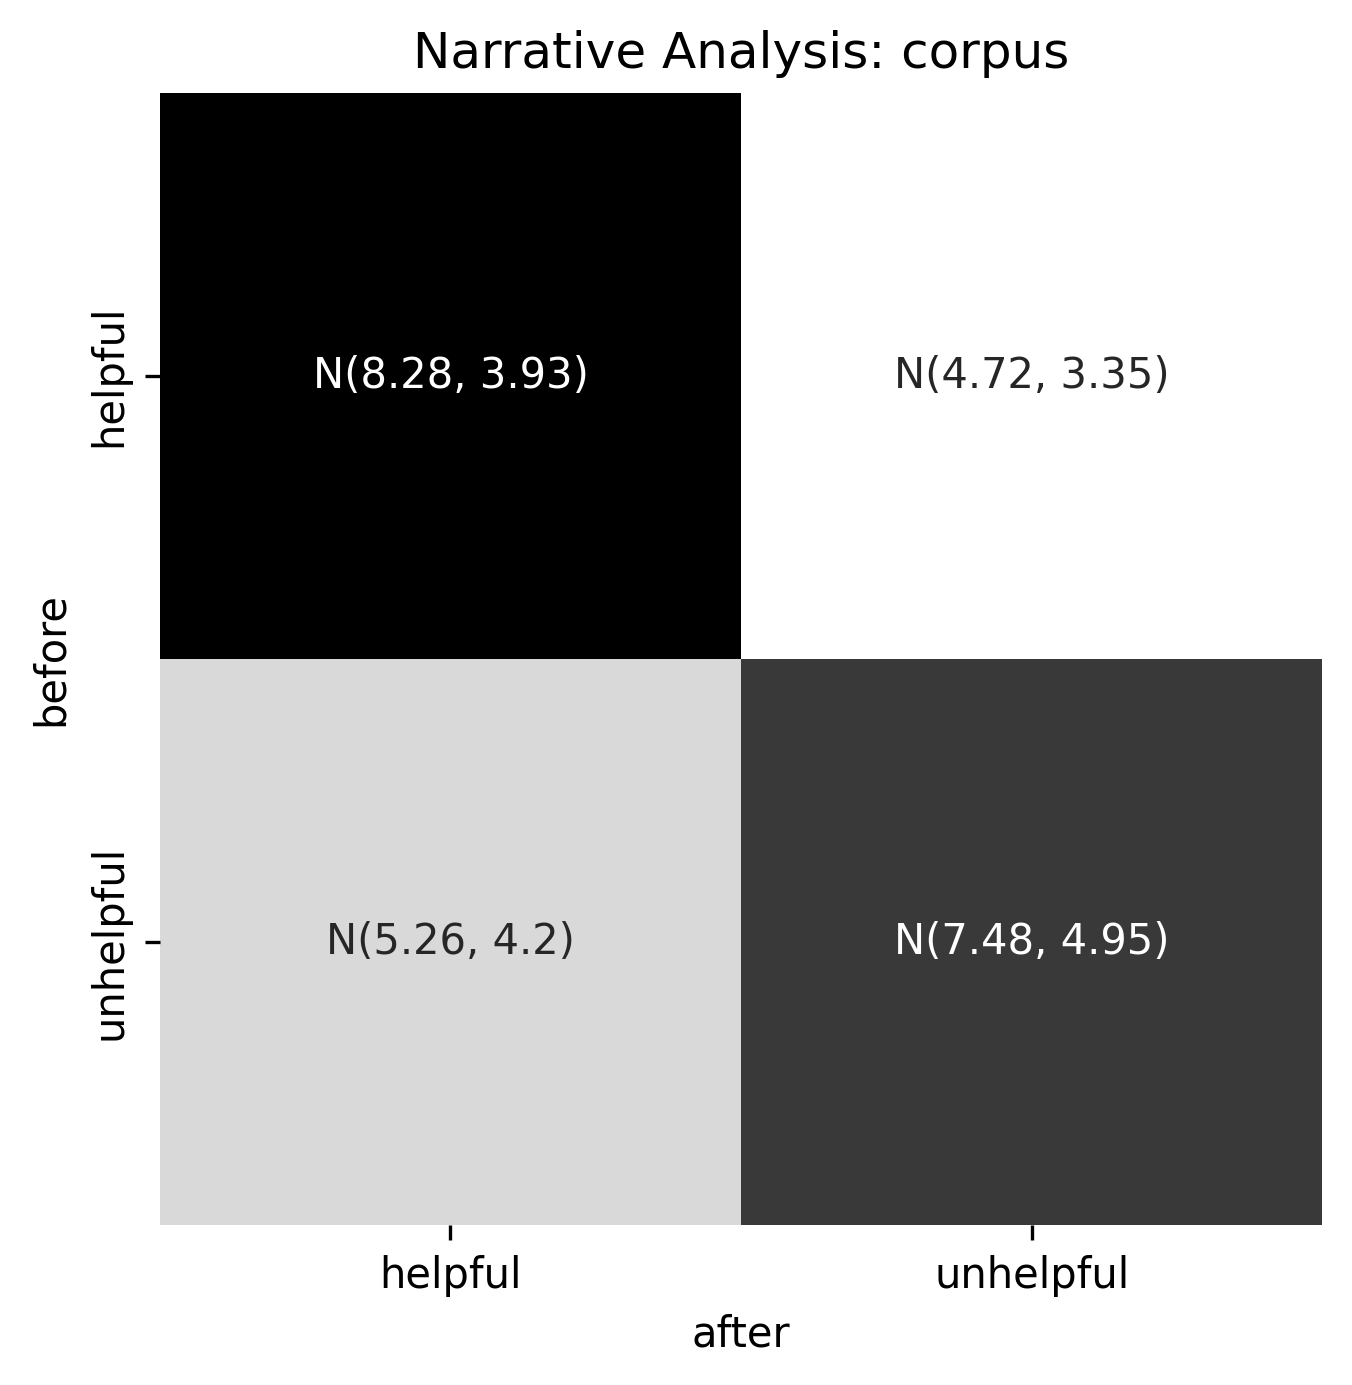

In [7]:
# Load experiment data
import yaml
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import yaml
import pickle

# with open("results.pkl", "rb") as f:
with open(getdir("results.pkl"), "rb") as f:
    results = pickle.load(f)


def plot(experiment, ax):
    distributions = experiment["distributions"]
    experiment_name = experiment["name"]

    # Remove distributions containing the neutral set if it's empty
    if len(experiment["labelled"]["neutral"]) == 0:
        distributions = {k: v for k, v in distributions.items() if "neutral" not in k}

    labels = []
    for key in distributions:
        labels.extend(key)
    labels = set(labels)

    data = [
        {
            "before": label_set,
            "after": other_label_set,
            "mean": round(
                distributions[(label_set, other_label_set)]["distribution"][0], 2
            ),
            "dist": "N({}, {})".format(
                round(
                    distributions[(label_set, other_label_set)]["distribution"][0], 2
                ),
                round(
                    distributions[(label_set, other_label_set)]["distribution"][1], 2
                ),
            ),
        }
        # for label_set in ["unhelpful", "helpful"]
        # for other_label_set in ["unhelpful", "helpful"]
        for label_set in labels
        for other_label_set in labels
    ]

    # Show like a confusion matrix
    df = pd.DataFrame(data)

    # Pivot
    labels = df.pivot(index="before", columns="after", values="dist").values
    df = df.pivot(index="before", columns="after", values="mean")

    # Negate means
    df = df.applymap(lambda x: -x)

    # Plot the figure on the given axes
    sns.heatmap(df, annot=labels, fmt="", cmap="gray", cbar=False, ax=ax)

    # Set title
    ax.set_title("Narrative Analysis: {}".format(experiment_name))


if len(results) > 0:
    # Plot all experiments in a single figure with subplots
    print("Plotting {} experiment(s)".format(len(results)))
    fig, axes = plt.subplots(1, len(results), figsize=(5 * len(results), 5), dpi=300)
    for i, experiment_name in enumerate(results):
        if len(results) == 1:
            plot(results[experiment_name], axes)
        else:
            plot(results[experiment_name], axes[i])

    # Solid white background
    fig.patch.set_facecolor("white")

    # Show figure
    fig.show()

    # Save the figure to a file
    # Create results dir if necessary
    if not os.path.exists(getdir("figures/")):
        os.mkdir(getdir("figures"))

    figpath = getdir(
        "figures/results_{}_{}_{}.png".format(
            MODEL.replace("/", "_"), CONDITIONERS, SAMPLE_RATE
        )
    )

    fig.savefig(figpath, bbox_inches="tight", pad_inches=0.1)

else:
    print("No results to plot")

In [8]:
# distributions

In [9]:
# Load the results from pickle
import os
import pandas as pd
import pickle


# with open("results.pkl", "rb") as f:
with open(getdir("results.pkl"), "rb") as f:
    results = pickle.load(f)

# print(results)

rows = []

for experiment in results:
    distributions = results[experiment]["distributions"]
    # print(distributions)

    for a, b in distributions:
        # print(a, b)
        for datum in distributions[(a, b)]["results"]:
            row = {
                "experiment": experiment,
                "a": a,
                "b": b,
                "x": datum["x"],
                "y": datum["y"],
                "likelihood_delta": datum["likelihood_delta"],
            }
            rows.append(row)

# Convert to dataframe
df = pd.DataFrame(rows)

# Make sure the results directory exists
# if not os.path.exists("results"):
#     os.makedirs("results")

# Save to CSV
# df.to_csv(RESULTS_DIR + ctx.model + "_" + str(ctx.conditioners) + "_" + str(ctx.sample_rate) + ".csv", index=False)
outname = f"{MODEL}_{CONDITIONERS}_{SAMPLE_RATE}.csv"
print("Saving results to {}".format(outname))
df.to_csv(getdir(outname), index=False)

Saving results to babbage-002_1_-100.csv
